In [92]:
import sys
import os
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
sys.path.append(SCRIPT_DIR)
import helper
from utils import data_utils
from utils import lmdb_dataset
import matplotlib.pyplot as plt
import torch
from model import models
import json
import os
from model import lightning_models
import math
import torchvision
from torchvision import datasets
import analysis_utils
import numpy as np
from torchvision.transforms import v2
from scipy.optimize import curve_fit


In [58]:
batch_size = 8
model_dir = "../best_imagenet"

In [59]:
config = helper.Config(model_dir,default_config_file="../default_configs/default_config_cifar10.ini")
model = torchvision.models.resnet50(pretrained=False)
model.fc = torch.nn.Identity()
model.load_state_dict(torch.load(os.path.join(model_dir,"ssl","last_epoch_backbone_resnet50.ckpt"),weights_only=True))
device = torch.device("cuda:0")  # Use GPU 0
backbone = model.to(device)

Loading default settings...
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[KNN]does not exist in the config file
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[KNN]does not exist in the config file
[INFO]
num_nodes = 4
gpus_per_node = 4
cpus_per_gpu = 12
prefetch_factor = 2
precision = 16-mixed
fix_random_seed = True
strategy = ddp
if_profile = False

[DATA]
dataset = IMAGENET1K
n_views = 4
n_trans = 1
augmentations = ['RandomResizedCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip', 'RandomSolarize']
augmentation_package = albumentations
crop_size = [224]
crop_min_scale = [0.08]
crop_max_scale = [1.0]
hflip_prob = [0.5]
blur_kernel_size = [23]
blur_prob = [0.5]
grayscale_prob = [0.2]
jitter_brightness = [0.8]
jitter_contrast = [0.8]
jitter_saturation = [0.8]
jitter_hue = [0.2]
jitter_prob = [0.8]
solarize_prob = [0.0]
imagenet_train_dir = ../datasets/imagenet1k/train/train.lmdb
imagenet_va

In [60]:
val_dir = config.DATA["imagenet_val_dir"]
mean= [0.485, 0.456, 0.406]
std= [0.229, 0.224, 0.225]
if val_dir.endswith("lmdb"):
    img_type = "PIL"
    test_dataset = lmdb_dataset.ImageFolderLMDB(val_dir,img_type=img_type)
else:
    test_dataset = datasets.ImageFolder(root=val_dir)
test_transforms = [v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32,scale=True),
                                v2.Normalize(mean=mean,std=std),
                                v2.Resize(size=256,interpolation=v2.InterpolationMode.BICUBIC),
                                v2.CenterCrop(size=224)])]
test_dataset = data_utils.WrappedDataset(test_dataset,test_transforms,n_views=1,aug_pkg="torchvision")
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                              num_workers = 4,pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 640x480 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

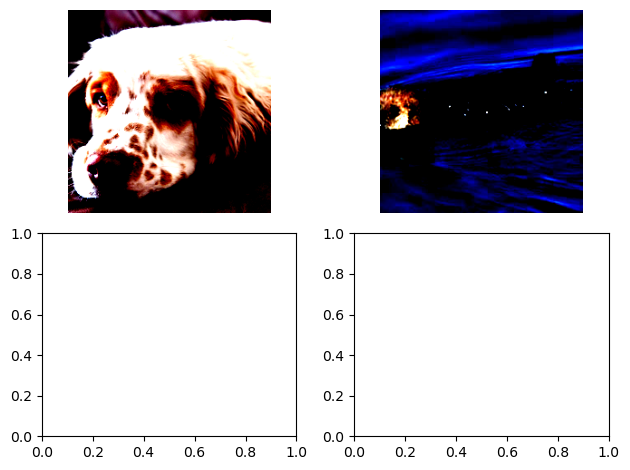

In [61]:
imgs,labels = next(iter(test_loader))
img_list, label_list = [],[]
for i_view in range(1):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)

In [75]:
def sample_representations(backbone,test_dataset,batch_size=8,count=2400):
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                              num_workers = 4,pin_memory=True)
    representations = []
    i = 0
    for i,data in enumerate(test_loader):
        imgs,labels = data
        if i > count - 1:
            break
        imgs = torch.cat(imgs,dim=0).to(device)
        with torch.no_grad():
            preds = backbone(imgs)
            preds = torch.reshape(preds,(1,batch_size,preds.shape[-1])) # n_veiws = 1
            representations.append(torch.squeeze(preds).detach().cpu().numpy())
    reps = np.concatenate(representations) # shape = (count*ouput_dim)
    center = np.mean(reps,axis=0,keepdims=True)
    print(reps.shape)
    print(center.shape)
    reps = reps - center
    #cov = np.einsum("ij,ik->jk",reps,reps) 
    cov = np.matmul(np.transpose(reps),reps)
    print(cov.shape)
    cov /= (reps.shape[0]-1.0)
    return cov

In [76]:
cov = sample_representations(backbone,test_dataset,count=2000)
vals,vecs = np.linalg.eig(cov)
pr = (np.sum(vals)**2) /np.sum(vals*vals)

(16000, 2048)
(1, 2048)
(2048, 2048)


In [77]:
pr

136.59790617929906

In [83]:
sorted_vals = np.sort(vals)[::-1]

In [143]:
rng = [30,1000]
def power_law(x, c, p):
    return c * np.power(x, p)
popt, pcov = curve_fit(power_law, np.arange(rng[0],rng[1]), sorted_vals[rng[0]:rng[1]])
c, p = popt # Extract the fitted parameters

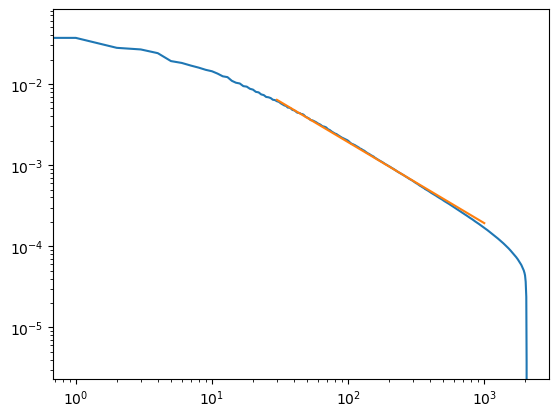

In [144]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.loglog(sorted_vals)
ax1.loglog(np.arange(rng[0],rng[1]),c*np.power(np.arange(rng[0],rng[1]),p))

In [145]:
pcov

array([[ 8.74668087e-07, -1.03963793e-06],
       [-1.03963793e-06,  1.27709096e-06]])